In [1]:
%matplotlib inline
import numpy as np
import random
import matplotlib.pyplot as plt
import matplotlib.cm as cm
plt.style.use('seaborn-dark')
import warnings
warnings.filterwarnings("ignore")
import matplotlib.pyplot as plt
import matplotlib as mpl
plt.rc('font', size=14)

In [2]:
class KMeans():
    def __init__(self, K, X = None, N = 0):
        self.K = K
        if X is None:
            if N == 0:
                raise Exception("If no data is provided, \
                                 a parameter N (number of points) is needed")
            else:
                self.N = N
                self.X = self._init_board_gauss(N, K)
        else:
            self.X = X
            self.N = len(X)
        self.mu = None
        self.clusters = None
        self.method = None
        
    def _init_board_gauss(self, N, k):
        n = float(N)/k
        X = []
        for i in range(k):
            c = (random.uniform(-10, 10), random.uniform(-10, 10))
            s = random.uniform(0.50, 1.5)
            x = []
            while len(x) < n:
                a,b = np.array([np.random.normal(c[0],s),np.random.normal(c[1],s)])
                # Continue drawing points from the distribution in the range [-1,1]
                if abs(a) < 10 and abs(b) < 10:
                    x.append([a,b])
            X.extend(x)
        X = np.array(X)[:N]
        return X

    def plot_board(self):
        X = self.X
        fig = plt.figure(figsize=(5, 5))
        plt.xlim(-10, 10)
        plt.ylim(-10, 10)
        if self.mu and self.clusters:
            mu = self.mu
            clus = self.clusters
            K = self.K
            cmap = cm.get_cmap("hsv", K+1)
            for m, clu in clus.items():
                plt.plot(mu[m][0], mu[m][1], 'o', marker='*', \
                         markersize=12, color=cmap(m))
                plt.plot(list(zip(*clus[m]))[0], list(zip(*clus[m]))[1], '.', \
                         markersize=8, color=cmap(m), alpha=0.5)
        else:
            plt.plot(list(zip(*X))[0], list(zip(*X))[1], '.', alpha=0.5)
        if self.method == '++':
            tit = 'K-means++'
        else:
            tit = 'K-means with random initialization'
        pars = 'N=%s, K=%s' % (str(self.N), str(self.K))
        plt.title('\n'.join([pars, tit]), fontsize=16)
        plt.savefig('kpp_N%s_K%s.png' % (str(self.N), str(self.K)), \
                    bbox_inches='tight', dpi=200)
        
    def _cluster_points(self):
        mu = self.mu
        clusters = {}
        for x in self.X:
            bestmukey = min([(i[0], np.linalg.norm(x-mu[i[0]])) \
                             for i in enumerate(mu)], key=lambda t:t[1])[0]
            try:
                clusters[bestmukey].append(x)
            except KeyError:
                clusters[bestmukey] = [x]
        self.clusters = clusters

    def _reevaluate_centers(self):
        clusters = self.clusters
        newmu = []
        keys = sorted(self.clusters.keys())
        for k in keys:
            newmu.append(np.mean(clusters[k], axis = 0))
        self.mu = newmu

    def _has_converged(self):
        K = len(self.oldmu)
        return(set([tuple(a) for a in self.mu]) == \
               set([tuple(a) for a in self.oldmu])\
               and len(set([tuple(a) for a in self.mu])) == K)

    def find_centers(self, method = 'random'):
        self.method = method
        X = self.X
        K = self.K
        self.oldmu = random.sample(X.tolist(), K)
        if method != '++':
            # Initialize to K random centers
            self.mu = random.sample(X.tolist(), K)
        while not self._has_converged():
            self.oldmu = self.mu
            # Assign all points in X to clusters
            self._cluster_points()
            # Reevaluate centers
            self._reevaluate_centers()
        return self.clusters

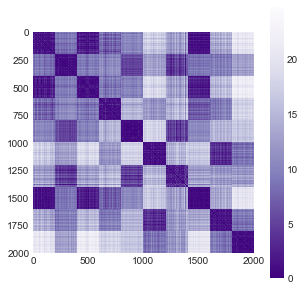

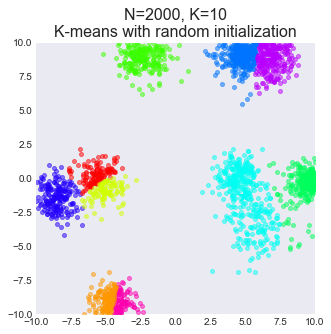

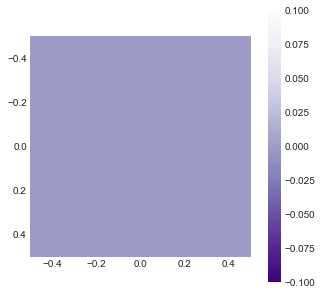

In [3]:
kmeans = KMeans(10, N = 2000)
D = (kmeans.X[:,0][:, np.newaxis] - kmeans.X[:,0]) ** 2
D += (kmeans.X[:,1][:, np.newaxis] - kmeans.X[:,1]) ** 2
D = np.sqrt(D)

plt.figure(figsize=(5, 5))
plt.imshow(D, cmap='Purples_r')
plt.colorbar(orientation='vertical', pad=0.06)

clust = kmeans.find_centers()
kmeans.plot_board()
i  = np.argsort(clust)
blobs2 = kmeans.X[i, :]

D = (blobs2[:,0][:, np.newaxis] - blobs2[:,0]) ** 2
D += (blobs2[:,1][:, np.newaxis] - blobs2[:,1]) ** 2
D = np.sqrt(D)

plt.figure(figsize=(5, 5))
plt.imshow(D, cmap='Purples_r')
plt.colorbar(orientation='vertical', pad=0.06);

In [4]:
class KPlusPlus(KMeans):
    def _dist_next(self):
        cent = self.mu
        X = self.X
        D2 = np.array([min([np.linalg.norm(x-cent[-1:])**2, self.D2[idx]]) for idx, x in enumerate(X)])
        self.D2 = D2

    def _choose_next_center(self):
        self.probs = self.D2/self.D2.sum()
        self.cumprobs = self.probs.cumsum()
        r = random.random()
        ind = np.where(self.cumprobs >= r)[0][0]
        return(self.X[ind])

    def init_centers(self):
        self.mu = random.sample(self.X.tolist(), 1)
        self.D2 = np.array([np.linalg.norm(x-self.mu[0])**2 for x in self.X])
        while len(self.mu) < self.K:
            self.mu.append(self._choose_next_center())
            self._dist_next()

    def plot_init_centers(self):
        X = self.X
        fig = plt.figure(figsize=(5,5))
        plt.xlim(-10, 10)
        plt.ylim(-10, 10)
        plt.plot(list(zip(*X))[0], list(zip(*X))[1], '.', alpha=0.5)
        plt.plot(list(zip(*self.mu))[0], list(zip(*self.mu))[1], 'ro')
        plt.savefig('kpp_init_N%s_K%s.png' % (str(self.N),str(self.K)), \
                    bbox_inches='tight', dpi=200)

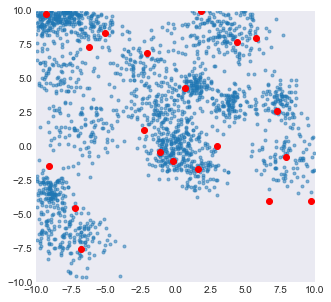

In [5]:
kplusplus = KPlusPlus(20, N = 2000)
kplusplus.init_centers()
kplusplus.plot_init_centers()

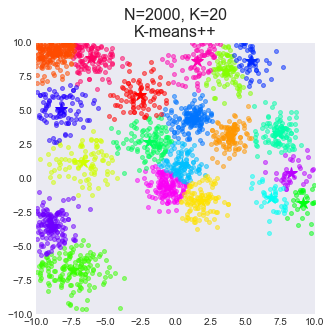

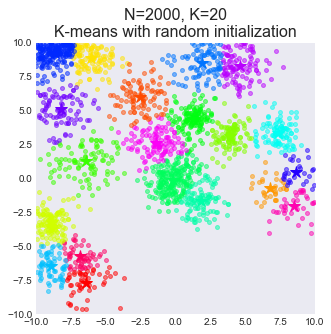

In [6]:
# k-means++ initialization
clust = kplusplus.find_centers(method='++')
kplusplus.plot_board()
# Random initialization
clust = kplusplus.find_centers()
kplusplus.plot_board()

In [7]:
from sklearn.cluster import KMeans
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_blobs
import pylab
import time

tests = [(100, 3), (1000, 4), (10000, 6), (1400, 25), (5000, 8), (600, 5), (1999, 7)]
times = []
for i in range(len(tests)):
    x, _ = make_blobs(n_samples = tests[i][0], n_features = 2, \
                      centers = tests[i][1], random_state = 4)
    true_time = time.time()
    true_cl = KMeans(n_clusters = tests[i][1], random_state = 4).fit_predict(x)
    true_time = time.time() - true_time
    t = time.time()
    ####
    kpp = KPlusPlus(K = tests[i][1], X = np.array(x)[:len(x)])
    kpp.init_centers()
    cl = kpp.find_centers(method='++')
    ####
    t = time.time() - t
    times.append(t / true_time)
    #overl = (true_cl == cl)
table = {"Time": times}
pd.DataFrame(table, index = tests)

,Time
"(100, 3)",0.857038
"(1000, 4)",10.720271
"(10000, 6)",71.178137
"(1400, 25)",48.364722
"(5000, 8)",133.606722
"(600, 5)",10.248833
"(1999, 7)",34.184299
